
# Hybrid Feature Learning: Daun Mangrove (7 Kelas)
**Ekstraksi Fitur Manual (Bentuk, Tekstur, Warna) + CNN (EfficientNetB0) — Fusi Langsung di Arsitektur**

Notebook ini menyiapkan pipeline lengkap untuk klasifikasi daun mangrove (7 kelas) dengan pendekatan hybrid:
1. **Segmentasi daun** → membuat *mask* dari gambar.
2. **Fitur manual**:
   - **Bentuk**: area relatif, perimeter relatif, form factor (4πA/P²), aspect ratio, extent, solidity, eccentricity, **Hu moments (7)**.
   - **Tekstur**: **GLCM** (mean atas jarak {1, 2, 4} & sudut {0°, 45°, 90°, 135°}) → contrast, dissimilarity, homogeneity, ASM, energy, correlation; **LBP (uniform)** histogram.
   - **Warna**: mean & std kanal **HSV** di area daun.
3. **Fusi fitur**: vektor fitur manual digabung langsung dengan representasi CNN (EfficientNetB0) → **model dua input**.
4. **Pipeline training**: ekstraksi → DataFrame → **StandardScaler (fit di train)** → `tf.data` jadi **((image_tensor, manual_vector), label)** → train/eval.
5. **Artefak** yang disimpan: 
   - `artifacts/best_hybrid.keras` (model)
   - `artifacts/meta.json` (urutan kolom fitur, daftar kelas, img_size)
   - `artifacts/scaler.pkl`, `artifacts/label_encoder.pkl`

> **Struktur dataset yang dianjurkan**
```
dataset_leaves/
  ├─ KelasA/
  │   ├─ img001.jpg
  │   └─ ...
  ├─ KelasB/
  └─ ... (hingga total 7 kelas)
```


## 1) Instalasi Dependensi (jika perlu)

In [1]:

# Jalankan sekali jika paket belum terpasang di environment Anda.
# Jika pakai GPU/versi TF lain, silakan sesuaikan.
# !pip install opencv-python scikit-image tensorflow==2.15.* pandas scikit-learn tqdm


## 2) Import & Konfigurasi Umum

In [2]:

import os, sys, json, glob, math, random, pickle, warnings
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Path & Hyperparams
DATA_DIR = "mydata"   # Ganti sesuai lokasi dataset Anda
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
VAL_SIZE = 0.10
TEST_SIZE = 0.10
MIN_AREA_RATIO = 0.005  # minimal area kontur terbesar terhadap area gambar

ARTIFACT_DIR = "artifactsv3"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


## 3) Utilitas: Listing File, Segmentasi, Ekstraksi Fitur Manual

In [3]:

def list_images_and_labels(root_dir: str) -> Tuple[List[str], List[str]]:
    """Scan subfolder sebagai label; kembalikan list filepath dan label_name."""
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    filepaths, labels = [], []
    if not os.path.isdir(root_dir):
        raise RuntimeError(f"Folder dataset tidak ditemukan: {root_dir}")
    for label_name in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, label_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            ext = os.path.splitext(fname)[1].lower()
            if ext in exts:
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(label_name)
    if len(filepaths) == 0:
        raise RuntimeError(f"Tidak ada gambar di {root_dir}. Pastikan struktur folder per kelas sudah benar.")
    return filepaths, labels


def segment_leaf_mask(bgr: np.ndarray) -> np.ndarray:
    """Membuat mask daun dari gambar BGR (0/255)."""
    if bgr is None or bgr.size == 0:
        return None
    h, w = bgr.shape[:2]
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]

    _, th_s = cv2.threshold(S, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, th_v = cv2.threshold(V, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = cv2.bitwise_or(th_s, th_v)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return mask
    areas = [cv2.contourArea(c) for c in cnts]
    c = cnts[int(np.argmax(areas))]

    out_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(out_mask, [c], -1, 255, thickness=cv2.FILLED)

    if cv2.contourArea(c) < MIN_AREA_RATIO * (h * w):
        out_mask = mask
    return out_mask


def shape_features(mask: np.ndarray) -> Dict[str, float]:
    """Fitur bentuk: area, perimeter, form factor, aspect ratio, extent, solidity, eccentricity, Hu(7)."""
    h, w = mask.shape[:2]
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return {k: 0.0 for k in [
            "area", "perimeter", "form_factor", "aspect_ratio", "extent",
            "solidity", "eccentricity", *[f"hu_{i+1}" for i in range(7)]
        ]}
    areas = [cv2.contourArea(c) for c in cnts]
    c = cnts[int(np.argmax(areas))]

    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    form_factor = 4 * math.pi * area / (perimeter ** 2 + 1e-8)

    x, y, bw, bh = cv2.boundingRect(c)
    aspect_ratio = bw / (bh + 1e-8)
    extent = area / (bw * bh + 1e-8)

    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = area / (hull_area + 1e-8) if hull_area > 0 else 0.0

    if len(c) >= 5:
        (xc, yc), (MA, ma), angle = cv2.fitEllipse(c)
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        eccentricity = math.sqrt(max(a*a - b*b, 0.0)) / (a + 1e-8) if a > 0 else 0.0
    else:
        eccentricity = 0.0

    moments = cv2.moments(mask)
    hu = cv2.HuMoments(moments).flatten()
    hu_log = [(-1 if h < 0 else 1) * math.log10(abs(h) + 1e-30) for h in hu]

    feats = {
        "area": float(area / (h * w)),
        "perimeter": float(perimeter / (h + w)),
        "form_factor": float(form_factor),
        "aspect_ratio": float(aspect_ratio),
        "extent": float(extent),
        "solidity": float(solidity),
        "eccentricity": float(eccentricity),
    }
    for i, v in enumerate(hu_log):
        feats[f"hu_{i+1}"] = float(v)
    return feats


def texture_features(gray: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
    """GLCM (mean multi-jarak & sudut) + LBP uniform histogram."""
    gray_masked = np.where(mask > 0, gray, 0)
    gray_q = (gray_masked / 32).astype(np.uint8)  # quantize 0..7
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(gray_q, distances=distances, angles=angles, levels=8, symmetric=True, normed=True)
    props = {}
    for prop in ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]:
        vals = graycoprops(glcm, prop)
        props[prop] = float(np.mean(vals))

    P, R = 8, 1
    lbp = local_binary_pattern(gray_masked, P=P, R=R, method="uniform")
    lbp_masked = lbp[mask > 0]
    n_bins = P + 2
    hist, _ = np.histogram(lbp_masked, bins=np.arange(0, n_bins + 1), density=True)
    lbp_feats = {f"lbp_{i}": float(hist[i]) for i in range(n_bins)}

    out = {f"glcm_{k}": v for k, v in props.items()}
    out.update(lbp_feats)
    return out


def color_features(bgr: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    mask3 = cv2.merge([mask, mask, mask])
    hsv_masked = cv2.bitwise_and(hsv, mask3)

    valid = mask > 0
    if np.count_nonzero(valid) == 0:
        return {"h_mean": 0.0, "s_mean": 0.0, "v_mean": 0.0, "h_std": 0.0, "s_std": 0.0, "v_std": 0.0}

    H = hsv[:, :, 0][valid]
    S = hsv[:, :, 1][valid]
    V = hsv[:, :, 2][valid]
    return {
        "h_mean": float(np.mean(H)), "s_mean": float(np.mean(S)), "v_mean": float(np.mean(V)),
        "h_std": float(np.std(H)),  "s_std": float(np.std(S)),  "v_std": float(np.std(V)),
    }


def extract_manual_features_from_bgr(bgr: np.ndarray) -> Dict[str, float]:
    mask = segment_leaf_mask(bgr)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    feats = {}
    feats.update(shape_features(mask))
    feats.update(texture_features(gray, mask))
    feats.update(color_features(bgr, mask))
    return feats


def extract_manual_features(image_path: str) -> Dict[str, float]:
    bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"Failed to read image: {image_path}")
    feats = extract_manual_features_from_bgr(bgr)
    feats["filepath"] = image_path
    return feats


def build_features_dataframe(paths: List[str], labels: List[str]) -> pd.DataFrame:
    rows = []
    for p, y in tqdm(list(zip(paths, labels)), total=len(paths), desc="Extracting manual features"):
        try:
            feats = extract_manual_features(p)
            feats["label"] = y
            rows.append(feats)
        except Exception as e:
            print(f"[WARN] skip {p} -> {e}")
    df = pd.DataFrame(rows)
    return df


## 4) Membangun DataFrame Fitur + Label

In [4]:

paths, labels = list_images_and_labels(DATA_DIR)
df = build_features_dataframe(paths, labels)
print("Jumlah sampel:", len(df))
print("Kolom fitur:", len([c for c in df.columns if c not in ('label','filepath')]))

# Tampilkan head
df.head(3)


Extracting manual features: 100%|██████████████████████████████████████████████████| 7070/7070 [01:15<00:00, 93.40it/s]


Jumlah sampel: 7070
Kolom fitur: 36


,area,perimeter,form_factor,aspect_ratio,extent,solidity,eccentricity,hu_1,hu_2,hu_3,...,lbp_8,lbp_9,h_mean,s_mean,v_mean,h_std,s_std,v_std,filepath,label
0,0.230469,1.086358,0.613502,2.294118,0.632814,0.966842,0.900375,-3.078911,-6.527167,-11.410478,...,0.085450,0.124968,49.492687,161.937131,53.433410,5.194696,59.925639,24.950816,mydata\Am\Am_1.jpg,Am
1,0.260132,1.076650,0.705009,0.736842,0.640902,0.978533,0.851776,-3.124757,-6.778387,-11.966657,...,0.102669,0.128679,41.359343,150.132786,60.653434,3.096407,43.842569,14.945842,mydata\Am\Am_10.jpg,Am
2,0.141388,0.782293,0.725811,1.857143,0.707112,0.980737,0.843622,-3.123857,-6.773389,-11.234084,...,0.096050,0.148025,39.398753,186.060291,74.557588,2.842841,43.791693,22.512027,mydata\Am\Am_100.jpg,Am


## 5) Split Train/Val/Test, Scaling Fitur Manual, dan Dataset `tf.data`

In [5]:

# Encode label
le = LabelEncoder()
y = le.fit_transform(df["label"].values)

# Kolom fitur manual
FEATURE_COLS = [c for c in df.columns if c not in ("label", "filepath")]

# Split stratified
X_tmp, X_test, y_tmp, y_test = train_test_split(df, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)
val_ratio = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=val_ratio, random_state=SEED, stratify=y_tmp)

# Scaling (fit hanya di train)
scaler = StandardScaler()
X_train_man = scaler.fit_transform(X_train[FEATURE_COLS].values)
X_val_man   = scaler.transform(X_val[FEATURE_COLS].values)
X_test_man  = scaler.transform(X_test[FEATURE_COLS].values)

def decode_image(path):
    img_bin = tf.io.read_file(path)
    img = tf.io.decode_image(img_bin, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = effnet_preprocess(img)
    return img

def make_tf_dataset(paths_np, manual_np, y_np, batch_size, shuffle):
    ds_paths = tf.data.Dataset.from_tensor_slices(paths_np)
    ds_imgs = ds_paths.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds_manual = tf.data.Dataset.from_tensor_slices(manual_np.astype(np.float32))
    ds_x = tf.data.Dataset.zip((ds_imgs, ds_manual))
    ds_y = tf.data.Dataset.from_tensor_slices(y_np.astype(np.int32))
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(paths_np)), seed=SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_tf_dataset(X_train["filepath"].values, X_train_man, y_train, BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(X_val["filepath"].values,   X_val_man,   y_val,   BATCH_SIZE, shuffle=False)
test_ds  = make_tf_dataset(X_test["filepath"].values,  X_test_man,  y_test,  BATCH_SIZE, shuffle=False)

len_train = len(X_train); len_val = len(X_val); len_test = len(X_test)
len_train, len_val, len_test, len(le.classes_)


(5656, 707, 707, 7)

## 6) Arsitektur Model (EfficientNetB0 + Fitur Manual)

In [6]:

def build_hybrid_model(n_manual: int, n_classes: int) -> tf.keras.Model:
    img_in = Input(shape=(*IMG_SIZE, 3), name="image_input")
    base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=img_in)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    man_in = Input(shape=(n_manual,), name="manual_input")
    m = layers.BatchNormalization()(man_in)
    m = layers.Dense(128, activation="relu")(m)
    m = layers.Dropout(0.2)(m)

    comb = layers.Concatenate()([x, m])
    comb = layers.Dense(256, activation="relu")(comb)
    comb = layers.BatchNormalization()(comb)
    comb = layers.Dropout(0.3)(comb)
    out = layers.Dense(n_classes, activation="softmax", name="pred")(comb)

    model = Model(inputs=[img_in, man_in], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_hybrid_model(n_manual=X_train_man.shape[1], n_classes=len(le.classes_))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,484,794 (17.11 MB)

 Trainable params: 4,441,675 (16.94 MB)

 Non-trainable params: 43,119 (168.44 KB)

## 7) Training Model dan Kurva (Accuracy/Loss)

Epoch 1/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.7297 - loss: 0.8075 - val_accuracy: 0.9434 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 2/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.9369 - loss: 0.2097 - val_accuracy: 0.9887 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 3/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.9622 - loss: 0.1182 - val_accuracy: 0.9731 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 4/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.9620 - loss: 0.1166 - val_accuracy: 0.8444 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 5/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.9644 - loss: 0.1185 - val_accuracy: 0.9901 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 6/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 669s 2s/step - accuracy: 0.9756 - loss: 0.0739 - val_accuracy: 0.9406 - val_loss: 0.2293 - learning_rate: 0.0010
Epoch 7/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9751 - loss: 0.

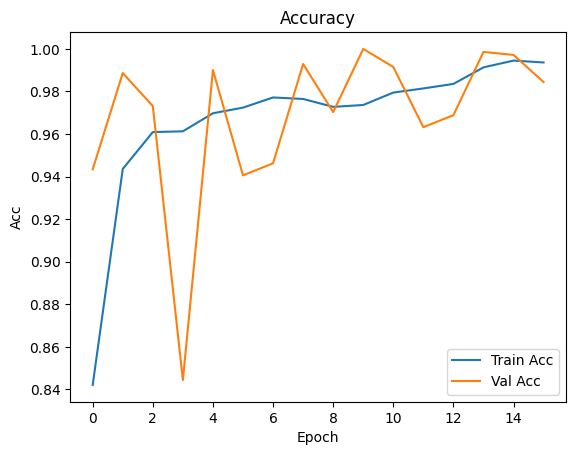

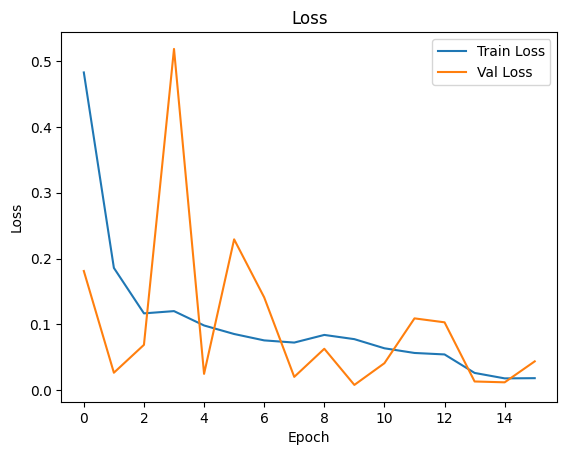

In [7]:

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor="val_loss"),
    ModelCheckpoint(os.path.join(ARTIFACT_DIR, "best_hybrid.keras"), monitor="val_accuracy", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot kurva (1 plot untuk accuracy, 1 plot untuk loss) — tanpa set warna khusus
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure()
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

plt.figure()
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## 8) Evaluasi di Test Set (Classification Report & Confusion Matrix)

Test accuracy: 0.9929

Classification Report (Test):
              precision    recall  f1-score   support

          Am       0.98      1.00      0.99       101
          Ao       1.00      0.98      0.99       101
          Bg       0.99      0.97      0.98       101
          Hl       1.00      1.00      1.00       101
          Lt       1.00      1.00      1.00       101
          Ra       0.98      1.00      0.99       101
          Sa       1.00      1.00      1.00       101

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707



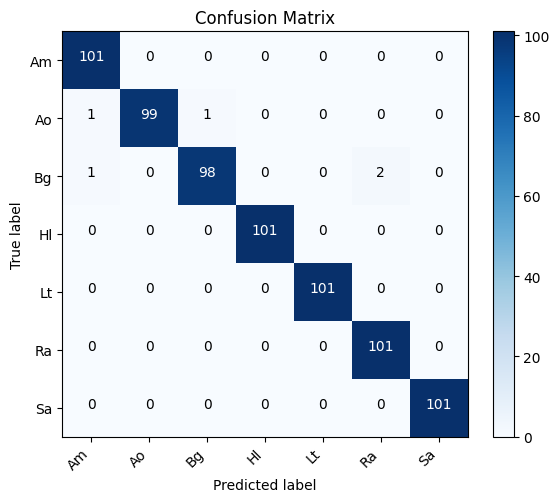

In [8]:

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(test_ds, verbose=0)
y_pred_cls = np.argmax(y_pred_probs, axis=1)
y_true = y_test  # karena urutan batch pada test_ds sama dengan X_test

print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred_cls, target_names=list(le.classes_)))

cm = confusion_matrix(y_true, y_pred_cls)

# Confusion Matrix plot (tanpa seaborn, satu plot, tanpa set warna khusus)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2. if cm.max() > 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Simpan artefak untuk inference konsisten
meta = {
    "img_size": list(IMG_SIZE),
    "classes": list(le.classes_),
    "feature_cols": FEATURE_COLS,
}
with open(os.path.join(ARTIFACT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

with open(os.path.join(ARTIFACT_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(ARTIFACT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)


## 9) Inference: Prediksi 1 Gambar

In [9]:

def load_artifacts(model_path: str = None):
    if model_path is None:
        model_path = os.path.join(ARTIFACT_DIR, "best_hybrid.keras")
    with open(os.path.join(ARTIFACT_DIR, "meta.json")) as f:
        meta = json.load(f)
    with open(os.path.join(ARTIFACT_DIR, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    with open(os.path.join(ARTIFACT_DIR, "label_encoder.pkl"), "rb") as f:
        le = pickle.load(f)
    model = tf.keras.models.load_model(model_path)
    return model, scaler, le, meta

def preprocess_single_image(path: str):
    img_bin = tf.io.read_file(path)
    img = tf.io.decode_image(img_bin, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = effnet_preprocess(img)
    return img.numpy()

def predict_image(image_path: str, model_path: str = None) -> Dict[str, object]:
    model, scaler, le, meta = load_artifacts(model_path)
    feats = extract_manual_features(image_path)
    X_man = np.array([[feats[c] for c in meta["feature_cols"]]], dtype=np.float32)
    X_man = scaler.transform(X_man)

    X_img = preprocess_single_image(image_path)
    X_img = np.expand_dims(X_img, axis=0)

    probs = model.predict([X_img, X_man], verbose=0)[0]
    top_idx = int(np.argmax(probs))
    pred_label = le.inverse_transform([top_idx])[0]
    return {
        "pred_label": pred_label,
        "probs": {le.classes_[i]: float(probs[i]) for i in range(len(le.classes_))},
        "manual_features": {k: float(feats[k]) for k in meta["feature_cols"]}
    }


### Contoh Pemanggilan Inference

In [10]:

# Ganti path di bawah ini ke gambar daun uji Anda
result = predict_image("uji/Ra2.jpg")
print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "pred_label": "Sa",
  "probs": {
    "Am": 0.12234596908092499,
    "Ao": 2.2400599430927315e-10,
    "Bg": 0.0010074347956106067,
    "Hl": 7.696221291553229e-05,
    "Lt": 1.1788745535312728e-09,
    "Ra": 0.07192543894052505,
    "Sa": 0.8046441674232483
  },
  "manual_features": {
    "area": 0.12807083129882812,
    "perimeter": 0.9182028094073758,
    "form_factor": 0.47722464848336976,
    "aspect_ratio": 3.259842519428359,
    "extent": 0.6385370306971284,
    "solidity": 0.9612471905284066,
    "eccentricity": 0.9445117374255576,
    "hu_1": -2.9794322940896207,
    "hu_2": -6.158721546973757,
    "hu_3": -10.651923393021443,
    "hu_4": -11.742526952385147,
    "hu_5": 22.979847687288377,
    "hu_6": 14.843846386445724,
    "hu_7": 23.326320221402696,
    "glcm_contrast": 0.043201090286357796,
    "glcm_dissimilarity": 0.025115585942017103,
    "glcm_homogeneity": 0.9892252132637944,
    "glcm_ASM": 0.7580386233883608,
    "glcm_energy": 0.8706509760736515,
    "glcm_corr

In [11]:

import math
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path

def _ensure_dir(d):
    Path(d).mkdir(parents=True, exist_ok=True)

def _preprocess_img_for_model(path, img_size, preprocess_fn):
    img_bin = tf.io.read_file(path)
    img = tf.io.decode_image(img_bin, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    img = preprocess_fn(img)
    return img.numpy()

def batch_predict_and_show(
    image_paths,
    model_path=None,
    save_annotated_dir=None,
    show=True,
    cols=4,
    topk=3,
    figsize_per_img=(3.2, 3.2),
    csv_out=None,
):
    """
    Prediksi banyak gambar sekaligus.
    - Menampilkan gambar + prediksi (opsional `show=True`)
    - Menyimpan annotated hasil prediksi (opsional `save_annotated_dir`)
    - Mengembalikan DataFrame ringkasan (filepath, pred_label, conf, topk)
    """
    model, scaler, le, meta = load_artifacts(model_path)
    feat_cols = meta["feature_cols"]
    img_size = tuple(meta["img_size"]) if "img_size" in meta else (224, 224)

    # Kumpulkan batch fitur manual & gambar
    X_man_list, X_img_list, kept_paths = [], [], []
    for p in image_paths:
        try:
            feats = extract_manual_features(p)
            vec = [float(feats.get(c, 0.0)) for c in feat_cols]
            X_man_list.append(vec)
            X_img_list.append(_preprocess_img_for_model(p, img_size, effnet_preprocess))
            kept_paths.append(p)
        except Exception as e:
            print(f"[WARN] skip {p} -> {e}")

    if len(kept_paths) == 0:
        raise RuntimeError("Tidak ada gambar yang berhasil diproses.")

    X_man = scaler.transform(np.asarray(X_man_list, dtype=np.float32))
    X_img = np.asarray(X_img_list, dtype=np.float32)

    probs = model.predict([X_img, X_man], verbose=0)
    top1_idx = np.argmax(probs, axis=1)
    top1_conf = probs[np.arange(len(probs)), top1_idx]
    top1_label = le.inverse_transform(top1_idx)

    # siapkan top-k string
    topk_list = []
    for i in range(len(probs)):
        idx_sorted = np.argsort(probs[i])[::-1][:topk]
        items = [f"{le.classes_[j]}:{probs[i, j]:.3f}" for j in idx_sorted]
        topk_list.append("; ".join(items))

    df = pd.DataFrame({
        "filepath": kept_paths,
        "pred_label": top1_label,
        "confidence": top1_conf,
        "topk": topk_list,
    })

    # Simpan CSV kalau diminta
    if csv_out:
        Path(csv_out).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(csv_out, index=False)

    # Simpan annotated images (opsional)
    if save_annotated_dir:
        _ensure_dir(save_annotated_dir)
        for p, label, conf in zip(kept_paths, top1_label, top1_conf):
            bgr = cv2.imread(p, cv2.IMREAD_COLOR)
            if bgr is None:
                continue
            txt = f"{label} ({conf:.2f})"
            cv2.putText(bgr, txt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 2, cv2.LINE_AA)
            out_path = Path(save_annotated_dir) / Path(p).name
            cv2.imwrite(str(out_path), bgr)

    # Tampilkan grid gambar + prediksi (opsional)
    if show:
        n = len(kept_paths)
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols*figsize_per_img[0], rows*figsize_per_img[1]))
        # Normalisasi shape axes agar 2D
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1:
            axes = np.array([axes])
        elif cols == 1:
            axes = np.array([[ax] for ax in axes])
        for i in range(rows*cols):
            r, c = divmod(i, cols)
            ax = axes[r, c]
            if i < n:
                bgr = cv2.imread(kept_paths[i], cv2.IMREAD_COLOR)
                if bgr is None:
                    ax.axis('off')
                    continue
                rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                ax.imshow(rgb)
                ax.set_title(f"{top1_label[i]} ({top1_conf[i]:.2f})", fontsize=9)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

    return df


Jumlah gambar uji: 5


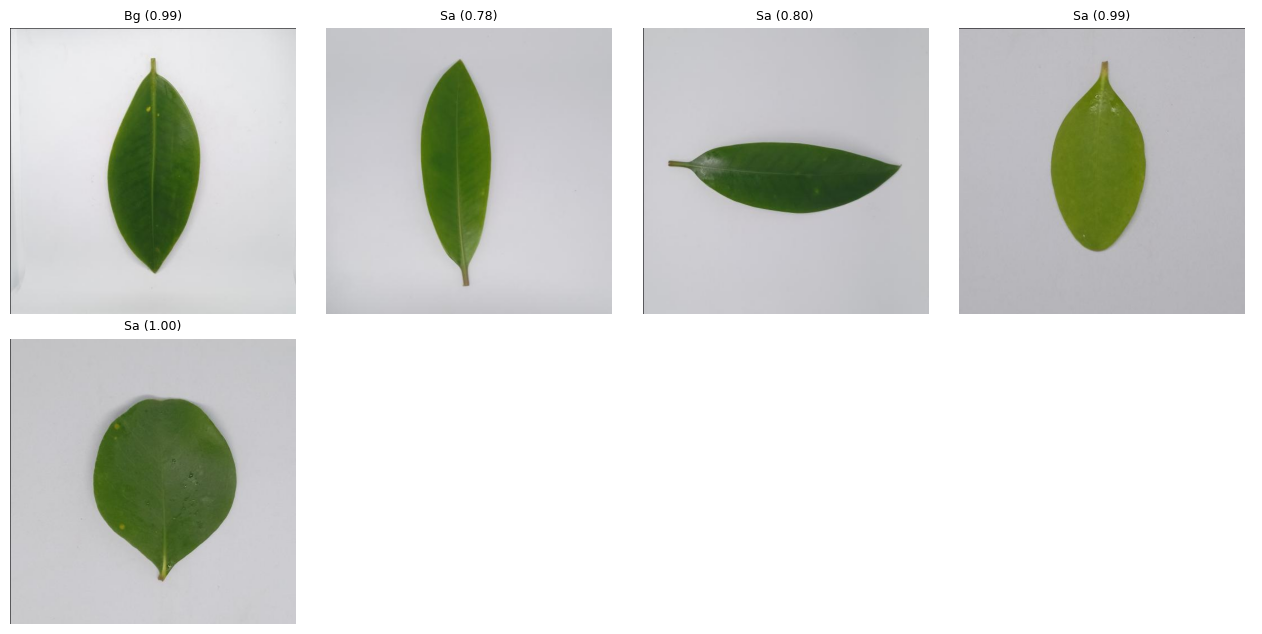

,filepath,pred_label,confidence,topk
0,uji\BG1.jpg,Bg,0.994722,Bg:0.995; Sa:0.005; Hl:0.000
1,uji\Ra1.jpg,Sa,0.778918,Sa:0.779; Bg:0.218; Hl:0.002
2,uji\Ra2.jpg,Sa,0.804644,Sa:0.805; Am:0.122; Ra:0.072
3,uji\sa1.jpg,Sa,0.994547,Sa:0.995; Hl:0.005; Ao:0.000
4,uji\sa2.jpg,Sa,0.999998,Sa:1.000; Ao:0.000; Hl:0.000


In [12]:

from glob import glob

# Contoh: semua .jpg di dalam folder uji (rekursif)
PATTERN = "uji/*.jpg"  # ganti sesuai kebutuhan, bisa juga "uji/*.png" atau daftar manual

test_paths = sorted(glob(PATTERN, recursive=True))
print("Jumlah gambar uji:", len(test_paths))

df_pred = batch_predict_and_show(
    test_paths,
    model_path=None,  # atau isi path model kustom .keras kalau berbeda
    save_annotated_dir="artifactsv3/pred_annotated",  # set None jika tidak perlu simpan
    show=True,
    cols=4,
    topk=3,
    figsize_per_img=(3.2, 3.2),
    csv_out="artifactsv3/predictions.csv",
)

# Lihat sebagian hasil
df_pred.head(10)
